# CIFAR10 with MLPs
Simple starter notebook to benchmark your own MLP with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

In [ ]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

In [ ]:
#@title Dataset Setup

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


In [ ]:
#@title Defining the MLP model
# 3072 (input) → 64 → 128 → 64 → 10 (output)
# change to
# 1024 → 512 → 256 → 128 → 10

class MLP(nn.Module):
  def __init__(self, input_size, num_classes, activation_function):
    super(MLP,self).__init__()
    # Defining activation functions and fully-connected layers
    self.activation_function = activation_function
    self.fc_input = nn.Linear(input_size, 1024)
    self.fc_hidden1 = nn.Linear(1024, 512)
    self.fc_hidden2 = nn.Linear(512, 256)
    self.fc_hidden3 = nn.Linear(256, 128)
    self.fc_output = nn.Linear(128, num_classes)

  def forward(self,x):
    x = self.activation_function(self.fc_input(x))
    x = self.activation_function(self.fc_hidden1(x))
    x = self.activation_function(self.fc_hidden2(x))
    x = self.activation_function(self.fc_hidden3(x))
    x = self.fc_output(x)
    return x

In [ ]:
#@title Defining metrics helper

def get_scores(targets, predictions):
    return {
        "accuracy": metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "precision": metrics.precision_score(targets, predictions, average="weighted"),
        "recall": metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score": metrics.f1_score(targets, predictions, average="weighted")
    }

In [ ]:
#@title Hyperparameters
input_size = 32*32*3 # 32x32 RGB images
num_classes = 10

learning_rate = 0.0005
num_epochs = 100
batch_size = 64

loss_function = nn.CrossEntropyLoss()

activation_function = nn.LeakyReLU()

In [ ]:
#@title Loaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
#@title Training loop with accuracy

# Build the model
mlp = MLP(input_size=input_size, num_classes=num_classes, activation_function=activation_function)
mlp.cuda()

# Setting optimizer up
optimizer = torch.optim.RMSprop(mlp.parameters(), lr=learning_rate, weight_decay=1e-5)

# Early stopping setup
best_loss = float('inf')
patience = 10
patience_counter = 0

losses = []
accuracies = []

# Start training epochs loop
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32 * 32 * 3).cuda()  # flattening images
        labels = labels.cuda()

        # Forward pass
        optimizer.zero_grad()
        outputs = mlp(images)

        # Loss calculation
        loss = loss_function(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{len(train_dataset) // batch_size}, Loss: {loss:.4f}')


    epoch_loss /= len(train_loader)
    epoch_accuracy = 100 * correct / total

    tqdm.write(f'Epoch {epoch + 1} average loss: {epoch_loss:.4f}, accuracy: {epoch_accuracy:.2f}%')
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)



    # Early stopping using loss value
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("Early stopping triggered.")
            break


  1%|          | 1/100 [00:17<28:34, 17.32s/it]

Epoch 1 average loss: 1.8284, accuracy: 33.28%


  2%|▏         | 2/100 [00:36<29:51, 18.28s/it]

Epoch 2 average loss: 1.6267, accuracy: 41.41%


  3%|▎         | 3/100 [00:53<28:36, 17.70s/it]

Epoch 3 average loss: 1.5408, accuracy: 44.53%


  4%|▍         | 4/100 [01:10<28:08, 17.58s/it]

Epoch 4 average loss: 1.4884, accuracy: 46.58%


  5%|▌         | 5/100 [01:28<28:01, 17.70s/it]

Epoch 5 average loss: 1.4454, accuracy: 47.96%


  6%|▌         | 6/100 [01:45<27:16, 17.41s/it]

Epoch 6 average loss: 1.4116, accuracy: 49.26%


  7%|▋         | 7/100 [02:02<26:43, 17.24s/it]

Epoch 7 average loss: 1.3803, accuracy: 50.21%


  8%|▊         | 8/100 [02:20<26:44, 17.44s/it]

Epoch 8 average loss: 1.3578, accuracy: 51.31%


  9%|▉         | 9/100 [02:37<26:24, 17.41s/it]

Epoch 9 average loss: 1.3364, accuracy: 51.83%


 10%|█         | 10/100 [02:55<26:19, 17.55s/it]

Epoch 10 average loss: 1.3147, accuracy: 52.84%


 11%|█         | 11/100 [03:12<25:57, 17.50s/it]

Epoch 11 average loss: 1.2914, accuracy: 53.83%


 12%|█▏        | 12/100 [03:30<25:38, 17.49s/it]

Epoch 12 average loss: 1.2787, accuracy: 53.93%


 13%|█▎        | 13/100 [03:48<25:39, 17.70s/it]

Epoch 13 average loss: 1.2592, accuracy: 54.53%


 14%|█▍        | 14/100 [04:05<25:06, 17.52s/it]

Epoch 14 average loss: 1.2440, accuracy: 55.39%


 15%|█▌        | 15/100 [04:22<24:40, 17.42s/it]

Epoch 15 average loss: 1.2240, accuracy: 56.01%


 16%|█▌        | 16/100 [04:40<24:38, 17.60s/it]

Epoch 16 average loss: 1.2109, accuracy: 56.40%


 17%|█▋        | 17/100 [04:57<24:07, 17.44s/it]

Epoch 17 average loss: 1.2039, accuracy: 56.55%


 18%|█▊        | 18/100 [05:15<23:45, 17.38s/it]

Epoch 18 average loss: 1.1871, accuracy: 57.38%


 19%|█▉        | 19/100 [05:33<23:48, 17.64s/it]

Epoch 19 average loss: 1.1730, accuracy: 57.93%


 20%|██        | 20/100 [05:50<23:22, 17.53s/it]

Epoch 20 average loss: 1.1578, accuracy: 58.17%


 21%|██        | 21/100 [06:08<23:24, 17.78s/it]

Epoch 21 average loss: 1.1478, accuracy: 58.76%


 22%|██▏       | 22/100 [06:26<22:58, 17.68s/it]

Epoch 22 average loss: 1.1357, accuracy: 58.82%


 23%|██▎       | 23/100 [06:43<22:36, 17.62s/it]

Epoch 23 average loss: 1.1255, accuracy: 59.65%


 24%|██▍       | 24/100 [07:02<22:39, 17.89s/it]

Epoch 24 average loss: 1.1163, accuracy: 59.62%


 25%|██▌       | 25/100 [07:19<22:08, 17.71s/it]

Epoch 25 average loss: 1.1038, accuracy: 60.18%


 26%|██▌       | 26/100 [07:37<21:51, 17.72s/it]

Epoch 26 average loss: 1.0924, accuracy: 60.69%


 27%|██▋       | 27/100 [07:55<21:31, 17.69s/it]

Epoch 27 average loss: 1.0804, accuracy: 60.98%


 28%|██▊       | 28/100 [08:12<21:05, 17.58s/it]

Epoch 28 average loss: 1.0706, accuracy: 61.31%


 29%|██▉       | 29/100 [08:30<21:04, 17.81s/it]

Epoch 29 average loss: 1.0576, accuracy: 61.82%


 30%|███       | 30/100 [08:47<20:35, 17.65s/it]

Epoch 30 average loss: 1.0543, accuracy: 61.75%


 31%|███       | 31/100 [09:05<20:13, 17.58s/it]

Epoch 31 average loss: 1.0422, accuracy: 62.35%


 32%|███▏      | 32/100 [09:23<20:11, 17.82s/it]

Epoch 32 average loss: 1.0346, accuracy: 62.47%


 33%|███▎      | 33/100 [09:41<19:44, 17.68s/it]

Epoch 33 average loss: 1.0252, accuracy: 62.81%


 34%|███▍      | 34/100 [09:58<19:25, 17.65s/it]

Epoch 34 average loss: 1.0159, accuracy: 63.20%


 35%|███▌      | 35/100 [10:16<19:12, 17.74s/it]

Epoch 35 average loss: 1.0089, accuracy: 63.31%


 36%|███▌      | 36/100 [10:33<18:47, 17.61s/it]

Epoch 36 average loss: 0.9985, accuracy: 63.84%


 37%|███▋      | 37/100 [10:52<18:43, 17.83s/it]

Epoch 37 average loss: 0.9899, accuracy: 64.16%


 38%|███▊      | 38/100 [11:09<18:17, 17.69s/it]

Epoch 38 average loss: 0.9810, accuracy: 64.32%


 39%|███▉      | 39/100 [11:26<17:50, 17.56s/it]

Epoch 39 average loss: 0.9697, accuracy: 64.73%


 40%|████      | 40/100 [11:45<17:43, 17.72s/it]

Epoch 40 average loss: 0.9617, accuracy: 65.15%


 41%|████      | 41/100 [12:02<17:14, 17.53s/it]

Epoch 41 average loss: 0.9529, accuracy: 65.26%


 42%|████▏     | 42/100 [12:19<16:52, 17.45s/it]

Epoch 42 average loss: 0.9493, accuracy: 65.76%


 43%|████▎     | 43/100 [12:37<16:45, 17.64s/it]

Epoch 43 average loss: 0.9404, accuracy: 65.93%


 44%|████▍     | 44/100 [12:54<16:20, 17.51s/it]

Epoch 44 average loss: 0.9305, accuracy: 66.46%


 45%|████▌     | 45/100 [13:13<16:16, 17.76s/it]

Epoch 45 average loss: 0.9199, accuracy: 66.59%


 46%|████▌     | 46/100 [13:30<15:49, 17.58s/it]

Epoch 46 average loss: 0.9134, accuracy: 66.87%


 47%|████▋     | 47/100 [13:47<15:24, 17.45s/it]

Epoch 47 average loss: 0.9100, accuracy: 66.96%


 48%|████▊     | 48/100 [14:05<15:21, 17.72s/it]

Epoch 48 average loss: 0.9015, accuracy: 67.28%


 49%|████▉     | 49/100 [14:22<14:57, 17.59s/it]

Epoch 49 average loss: 0.8895, accuracy: 67.68%


 50%|█████     | 50/100 [14:40<14:37, 17.56s/it]

Epoch 50 average loss: 0.8889, accuracy: 67.62%


 51%|█████     | 51/100 [14:58<14:27, 17.70s/it]

Epoch 51 average loss: 0.8763, accuracy: 68.10%


 52%|█████▏    | 52/100 [15:15<14:03, 17.58s/it]

Epoch 52 average loss: 0.8709, accuracy: 68.24%


 53%|█████▎    | 53/100 [15:33<13:54, 17.75s/it]

Epoch 53 average loss: 0.8686, accuracy: 68.31%


 54%|█████▍    | 54/100 [15:51<13:29, 17.60s/it]

Epoch 54 average loss: 0.8573, accuracy: 68.86%


 55%|█████▌    | 55/100 [16:08<13:06, 17.48s/it]

Epoch 55 average loss: 0.8533, accuracy: 69.01%


 56%|█████▌    | 56/100 [16:26<12:56, 17.66s/it]

Epoch 56 average loss: 0.8468, accuracy: 69.32%


 57%|█████▋    | 57/100 [16:43<12:34, 17.54s/it]

Epoch 57 average loss: 0.8355, accuracy: 69.66%


 58%|█████▊    | 58/100 [17:00<12:08, 17.34s/it]

Epoch 58 average loss: 0.8354, accuracy: 69.51%


 59%|█████▉    | 59/100 [17:18<12:03, 17.65s/it]

Epoch 59 average loss: 0.8303, accuracy: 69.69%


 60%|██████    | 60/100 [17:36<11:40, 17.50s/it]

Epoch 60 average loss: 0.8172, accuracy: 70.48%


 61%|██████    | 61/100 [17:53<11:26, 17.60s/it]

Epoch 61 average loss: 0.8154, accuracy: 70.61%


 62%|██████▏   | 62/100 [18:11<11:11, 17.68s/it]

Epoch 62 average loss: 0.8086, accuracy: 70.76%


 63%|██████▎   | 63/100 [18:29<10:49, 17.54s/it]

Epoch 63 average loss: 0.8058, accuracy: 70.83%


 64%|██████▍   | 64/100 [18:47<10:39, 17.77s/it]

Epoch 64 average loss: 0.7981, accuracy: 70.94%


 65%|██████▌   | 65/100 [19:04<10:14, 17.55s/it]

Epoch 65 average loss: 0.7859, accuracy: 71.44%


 66%|██████▌   | 66/100 [19:21<09:53, 17.46s/it]

Epoch 66 average loss: 0.7825, accuracy: 71.33%


 67%|██████▋   | 67/100 [19:39<09:45, 17.73s/it]

Epoch 67 average loss: 0.7764, accuracy: 71.94%


 68%|██████▊   | 68/100 [19:57<09:21, 17.54s/it]

Epoch 68 average loss: 0.7747, accuracy: 71.78%


 69%|██████▉   | 69/100 [20:14<09:03, 17.55s/it]

Epoch 69 average loss: 0.7669, accuracy: 72.03%


 70%|███████   | 70/100 [20:32<08:47, 17.60s/it]

Epoch 70 average loss: 0.7624, accuracy: 72.04%


 71%|███████   | 71/100 [20:49<08:29, 17.55s/it]

Epoch 71 average loss: 0.7521, accuracy: 72.55%


 72%|███████▏  | 72/100 [21:08<08:18, 17.81s/it]

Epoch 72 average loss: 0.7501, accuracy: 72.72%


 73%|███████▎  | 73/100 [21:25<07:57, 17.70s/it]

Epoch 73 average loss: 0.7457, accuracy: 72.76%


 74%|███████▍  | 74/100 [21:43<07:38, 17.65s/it]

Epoch 74 average loss: 0.7330, accuracy: 73.21%


 75%|███████▌  | 75/100 [22:01<07:24, 17.79s/it]

Epoch 75 average loss: 0.7336, accuracy: 73.20%


 76%|███████▌  | 76/100 [22:18<07:03, 17.64s/it]

Epoch 76 average loss: 0.7354, accuracy: 73.28%


 77%|███████▋  | 77/100 [22:35<06:41, 17.48s/it]

Epoch 77 average loss: 0.7224, accuracy: 73.54%


 78%|███████▊  | 78/100 [22:53<06:28, 17.67s/it]

Epoch 78 average loss: 0.7125, accuracy: 74.16%


 79%|███████▉  | 79/100 [23:11<06:08, 17.55s/it]

Epoch 79 average loss: 0.7132, accuracy: 73.99%


 80%|████████  | 80/100 [23:28<05:50, 17.52s/it]

Epoch 80 average loss: 0.7119, accuracy: 74.05%


 81%|████████  | 81/100 [23:46<05:33, 17.56s/it]

Epoch 81 average loss: 0.6992, accuracy: 74.50%


 82%|████████▏ | 82/100 [24:03<05:13, 17.44s/it]

Epoch 82 average loss: 0.6958, accuracy: 74.71%


 83%|████████▎ | 83/100 [24:21<05:01, 17.71s/it]

Epoch 83 average loss: 0.6895, accuracy: 74.95%


 84%|████████▍ | 84/100 [24:38<04:40, 17.51s/it]

Epoch 84 average loss: 0.6901, accuracy: 74.78%


 85%|████████▌ | 85/100 [24:55<04:20, 17.38s/it]

Epoch 85 average loss: 0.6906, accuracy: 74.96%


 86%|████████▌ | 86/100 [25:13<04:06, 17.61s/it]

Epoch 86 average loss: 0.6773, accuracy: 75.29%


 87%|████████▋ | 87/100 [25:30<03:46, 17.39s/it]

Epoch 87 average loss: 0.6765, accuracy: 75.38%


 88%|████████▊ | 88/100 [25:47<03:26, 17.25s/it]

Epoch 88 average loss: 0.6716, accuracy: 75.59%


 89%|████████▉ | 89/100 [26:05<03:10, 17.36s/it]

Epoch 89 average loss: 0.6722, accuracy: 75.46%


 90%|█████████ | 90/100 [26:22<02:52, 17.26s/it]

Epoch 90 average loss: 0.6595, accuracy: 75.90%


 91%|█████████ | 91/100 [26:39<02:34, 17.15s/it]

Epoch 91 average loss: 0.6592, accuracy: 76.03%


 92%|█████████▏| 92/100 [26:57<02:19, 17.45s/it]

Epoch 92 average loss: 0.6553, accuracy: 75.90%


 93%|█████████▎| 93/100 [27:14<02:01, 17.32s/it]

Epoch 93 average loss: 0.6503, accuracy: 76.36%


 94%|█████████▍| 94/100 [27:32<01:44, 17.42s/it]

Epoch 94 average loss: 0.6497, accuracy: 76.32%


 95%|█████████▌| 95/100 [27:49<01:27, 17.50s/it]

Epoch 95 average loss: 0.6388, accuracy: 76.80%


 96%|█████████▌| 96/100 [28:06<01:09, 17.32s/it]

Epoch 96 average loss: 0.6319, accuracy: 76.96%


 97%|█████████▋| 97/100 [28:24<00:52, 17.51s/it]

Epoch 97 average loss: 0.6362, accuracy: 76.93%


 98%|█████████▊| 98/100 [28:41<00:34, 17.37s/it]

Epoch 98 average loss: 0.6374, accuracy: 76.67%


 99%|█████████▉| 99/100 [28:58<00:17, 17.19s/it]

Epoch 99 average loss: 0.6260, accuracy: 77.21%


100%|██████████| 100/100 [29:16<00:00, 17.57s/it]

Epoch 100 average loss: 0.6243, accuracy: 77.19%


In [ ]:
#@title Evaluate model (accuracy, precision, recall)
mlp.eval()
predictions = []
labels = []
for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print("Scores of your model\n", scores)

Scores of your model
 {'accuracy': 0.5455, 'balanced_accuracy': np.float64(0.5455), 'precision': 0.5490881377901694, 'recall': 0.5455, 'f1_score': 0.5431728393322816}


# You can change/optimize this as you want
- Different optimizers, activation functions, etc
- Automatic hyperparameters optimization (Optuna)
- Regularization techniques
- Validation set to track metrics during epochs
- Transform input data
- ...

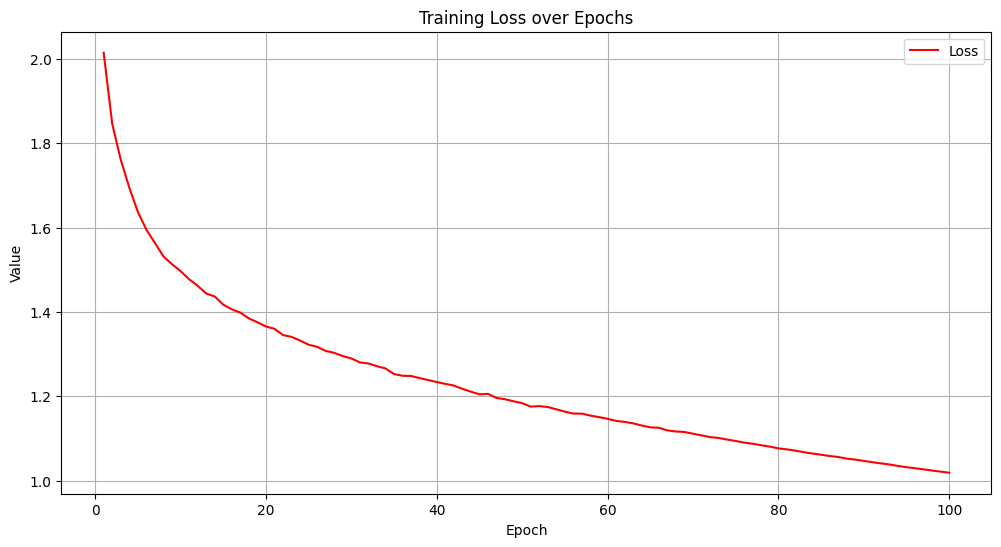

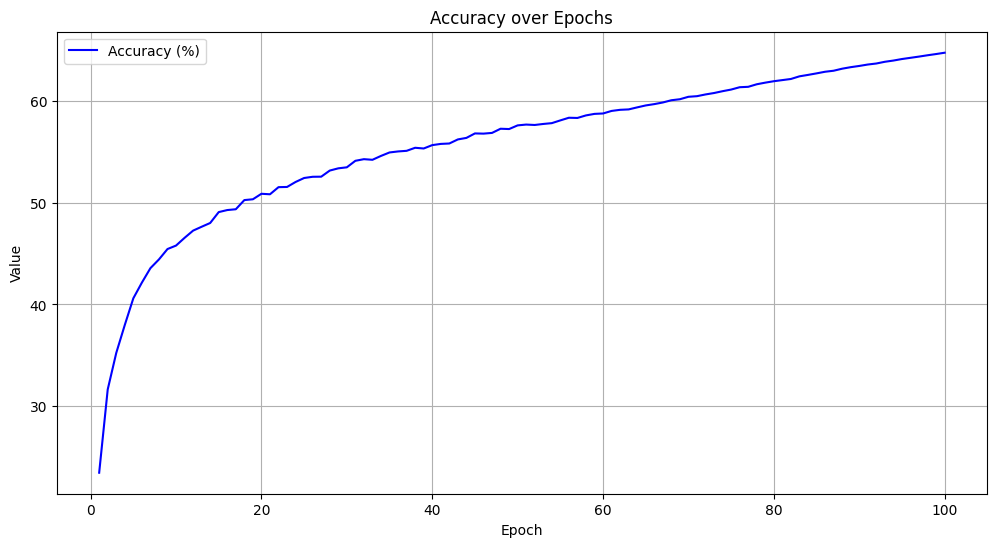

In [ ]:
import matplotlib.pyplot as plt

# Dados extraídos do seu texto
epochs = list(range(1, 101))
losses = [
    2.0144, 1.8459, 1.7610, 1.6946, 1.6374, 1.5950, 1.5635, 1.5316, 1.5131, 1.4969,
    1.4776, 1.4620, 1.4439, 1.4367, 1.4173, 1.4062, 1.3985, 1.3846, 1.3756, 1.3654,
    1.3601, 1.3453, 1.3408, 1.3322, 1.3223, 1.3173, 1.3077, 1.3030, 1.2954, 1.2898,
    1.2804, 1.2778, 1.2714, 1.2661, 1.2528, 1.2487, 1.2482, 1.2432, 1.2385, 1.2339,
    1.2295, 1.2255, 1.2178, 1.2110, 1.2047, 1.2059, 1.1961, 1.1931, 1.1882, 1.1839,
    1.1756, 1.1768, 1.1746, 1.1693, 1.1637, 1.1591, 1.1589, 1.1542, 1.1507, 1.1467,
    1.1418, 1.1394, 1.1359, 1.1308, 1.1265, 1.1255, 1.1192, 1.1167, 1.1155, 1.1114,
    1.1074, 1.1035, 1.1012, 1.0976, 1.0941, 1.0904, 1.0876, 1.0840, 1.0808, 1.0767,
    1.0742, 1.0713, 1.0675, 1.0644, 1.0616, 1.0585, 1.0562, 1.0523, 1.0500, 1.0470,
    1.0438, 1.0411, 1.0385, 1.0349, 1.0320, 1.0296, 1.0269, 1.0241, 1.0215, 1.0189
]

accuracies = [
    23.47, 31.65, 35.24, 37.99, 40.61, 42.15, 43.57, 44.43, 45.45, 45.79,
    46.55, 47.26, 47.64, 48.01, 49.08, 49.28, 49.36, 50.26, 50.34, 50.88,
    50.83, 51.53, 51.55, 52.04, 52.43, 52.55, 52.56, 53.16, 53.38, 53.48,
    54.12, 54.28, 54.22, 54.60, 54.94, 55.04, 55.10, 55.40, 55.33, 55.66,
    55.78, 55.82, 56.22, 56.37, 56.81, 56.79, 56.86, 57.27, 57.24, 57.60,
    57.68, 57.64, 57.74, 57.82, 58.09, 58.35, 58.33, 58.58, 58.73, 58.77,
    59.02, 59.13, 59.17, 59.37, 59.56, 59.69, 59.85, 60.07, 60.17, 60.41,
    60.47, 60.64, 60.78, 60.96, 61.12, 61.35, 61.39, 61.64, 61.80, 61.94,
    62.05, 62.16, 62.42, 62.56, 62.71, 62.87, 62.97, 63.17, 63.32, 63.44,
    63.58, 63.68, 63.85, 63.97, 64.12, 64.24, 64.36, 64.49, 64.61, 64.74
]

plt.figure(figsize=(12,6))

# plot loss
plt.plot(epochs, losses, label='Loss', color='red')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12,6))
# plot accuracy
plt.plot(epochs, accuracies, label='Accuracy (%)', color='blue')

plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Upload manual do arquivo se estiver no Colab
from google.colab import files
uploaded = files.upload()

# Leitura do arquivo Excel
df = pd.read_excel(list(uploaded.keys())[0])

# Corrigindo possíveis problemas com espaços ou formatações
df.columns = df.columns.str.strip()

# Corrigir valores inconsistentes no learning rate (substituir '0.00 1' por 0.001)
df['Learning Rate'] = df['Learning Rate'].replace('0.00 1', 0.001).astype(float)

# Exibir amostra dos dados
df.head()


Saving Registros de experimentos MLP (2).xlsx to Registros de experimentos MLP (2).xlsx


,Experimento,Arquitetura (Camadas/Neurônios),Função de Ativação,Batch Size,Learning Rate,Otimizador,Dropout,Weight Decay (L2),Data Augmentation,Épocas Treinadas,Acurácia Treino,Acurácia Teste,Precision,Recall,F1-Score,Observações,Membro
0,1,3072 -> 1024 → 512 → 256 → 128 → 10,ReLU,128.0,0.0005,Adam,NaN,NaN,Sim,43.0,NaN,0.34,0.39,0.34,0.32,NaN,Michel
1,2,3072 -> 1024 → 512 → 256 → 128 → 10,LeakyReLU,64.0,0.0005,RMSprop,NaN,0.00001,Sim,100.0,NaN,0.54,0.54,0.54,0.54,Terceira abordagem,Michel
2,3,3072 → 128 → 256 → 128 → 10,ReLU,16.0,0.0010,Adam,NaN,NaN,Sim,100.0,NaN,0.52,0.52,0.52,0.51,NaN,Lucas
3,4,3072 → 128 → 256 → 128 → 10,LeakyReLU,16.0,0.0010,Adam,NaN,NaN,Sim,100.0,NaN,0.54,0.56,0.54,0.54,NaN,Lucas
4,5,3072 → 128 → 256 → 128 → 10,LeakyReLU,64.0,0.0010,Adam,NaN,0.00001,Sim,100.0,NaN,0.54,0.58,0.54,0.54,Quinta abordagem,Lucas


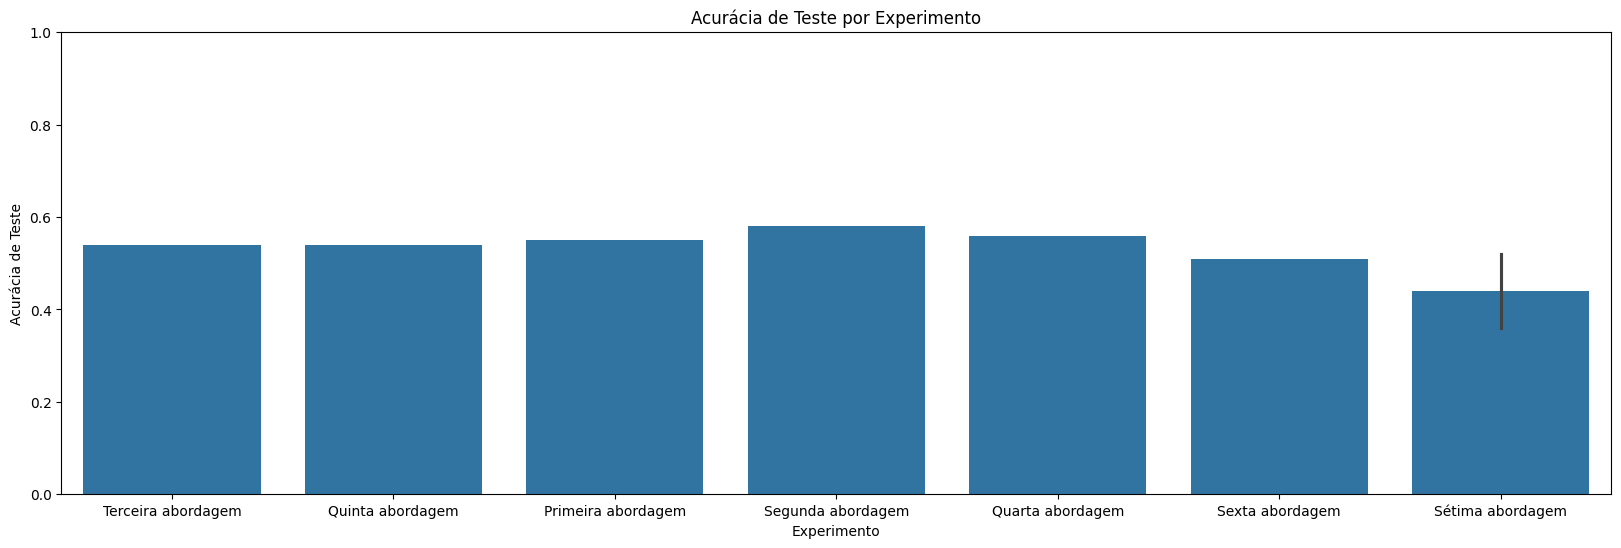

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(x='Observações', y='Acurácia Teste', data=df)
plt.title('Acurácia de Teste por Experimento')
plt.ylim(0, 1)
plt.xlabel('Experimento')
plt.ylabel('Acurácia de Teste')
plt.show()


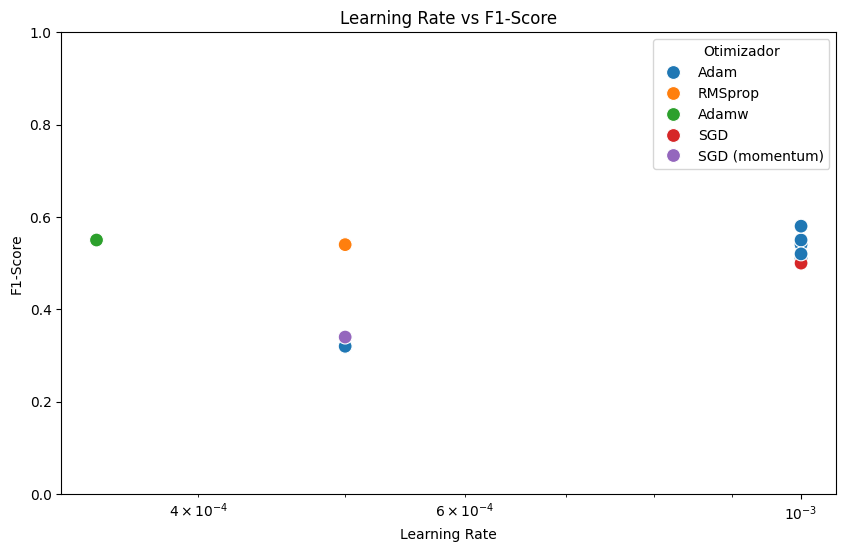

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='Learning Rate', y='F1-Score', hue='Otimizador', data=df, s=100)
plt.title('Learning Rate vs F1-Score')
plt.xscale('log')  # Escala log se os valores forem pequenos
plt.ylim(0, 1)
plt.show()


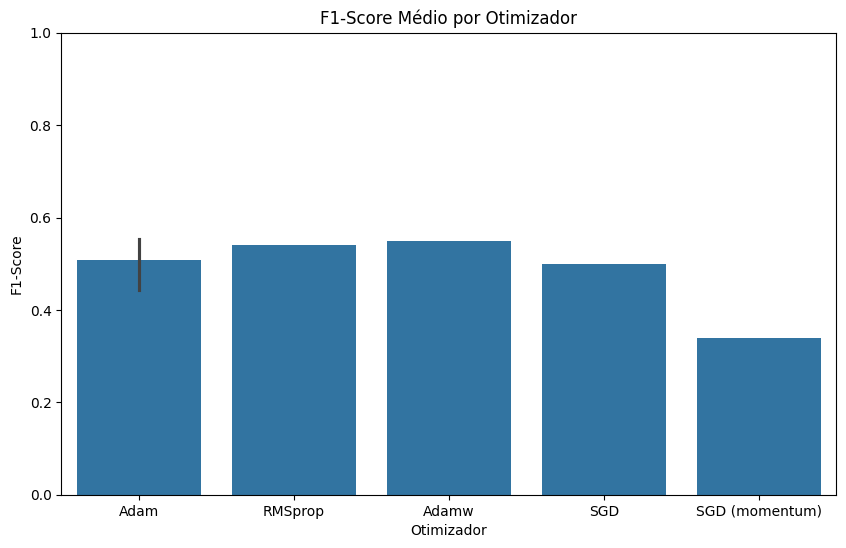

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Otimizador', y='F1-Score', data=df)
plt.title('F1-Score Médio por Otimizador')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()


In [ ]:
gere mais analise usando

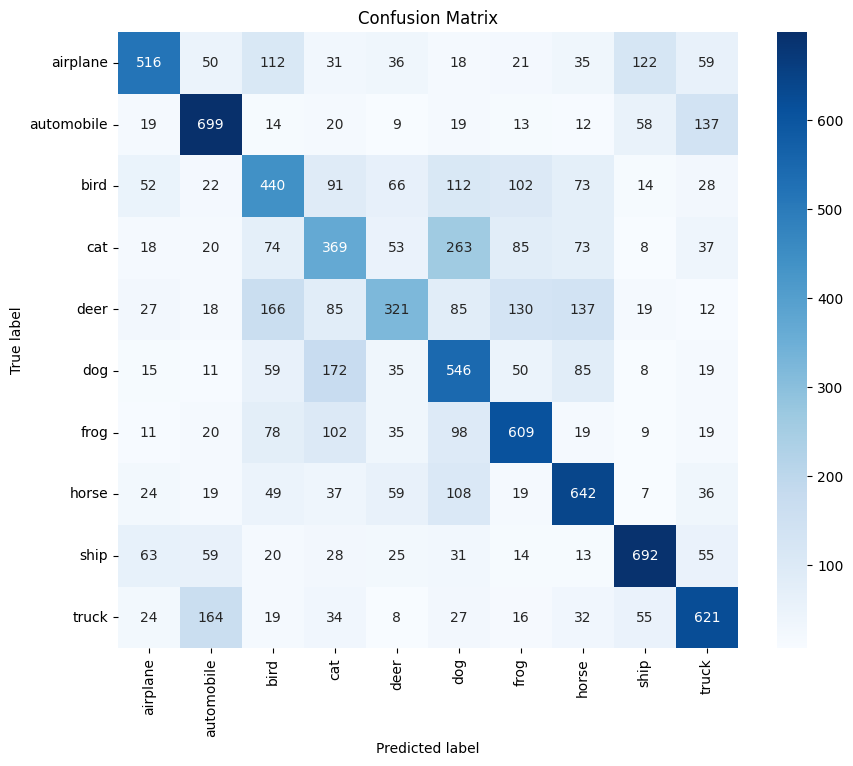

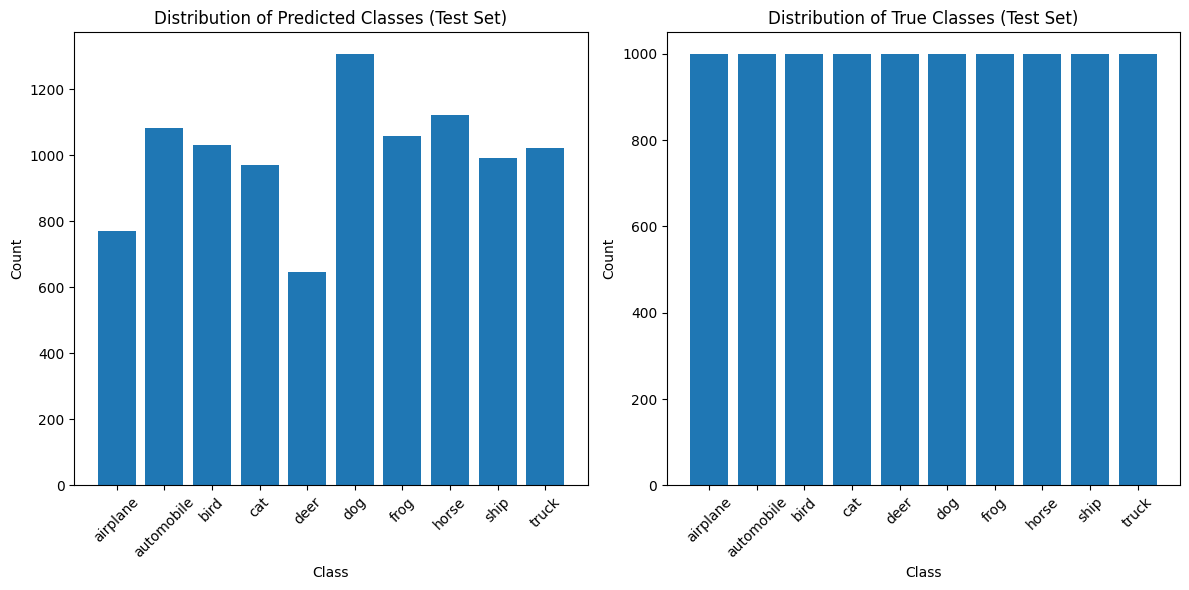


Classification Report:

              precision    recall  f1-score   support

    airplane       0.67      0.52      0.58      1000
  automobile       0.65      0.70      0.67      1000
        bird       0.43      0.44      0.43      1000
         cat       0.38      0.37      0.37      1000
        deer       0.50      0.32      0.39      1000
         dog       0.42      0.55      0.47      1000
        frog       0.58      0.61      0.59      1000
       horse       0.57      0.64      0.61      1000
        ship       0.70      0.69      0.69      1000
       truck       0.61      0.62      0.61      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.54     10000
weighted avg       0.55      0.55      0.54     10000



In [ ]:
# prompt: gere mais analise usando df

import matplotlib.pyplot as plt
# Pairplot para visualizar as relações entre algumas métricas
sns.pairplot(df[['Learning Rate', 'Acurácia Teste', 'F1-Score', 'Precisão', 'Recall']], diag_kind='kde')
plt.suptitle('Pairplot de Métricas', y=1.02)
plt.show()

# Correlação entre as métricas numéricas
plt.figure(figsize=(8, 6))
numeric_cols = ['Learning Rate', 'Acurácia Teste', 'F1-Score', 'Precisão', 'Recall']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação entre Métricas')
plt.show()

# Boxplot para comparar a distribuição da acurácia por otimizador
plt.figure(figsize=(10,6))
sns.boxplot(x='Otimizador', y='Acurácia Teste', data=df)
plt.title('Distribuição da Acurácia de Teste por Otimizador')
plt.ylabel('Acurácia de Teste')
plt.ylim(0, 1)
plt.show()

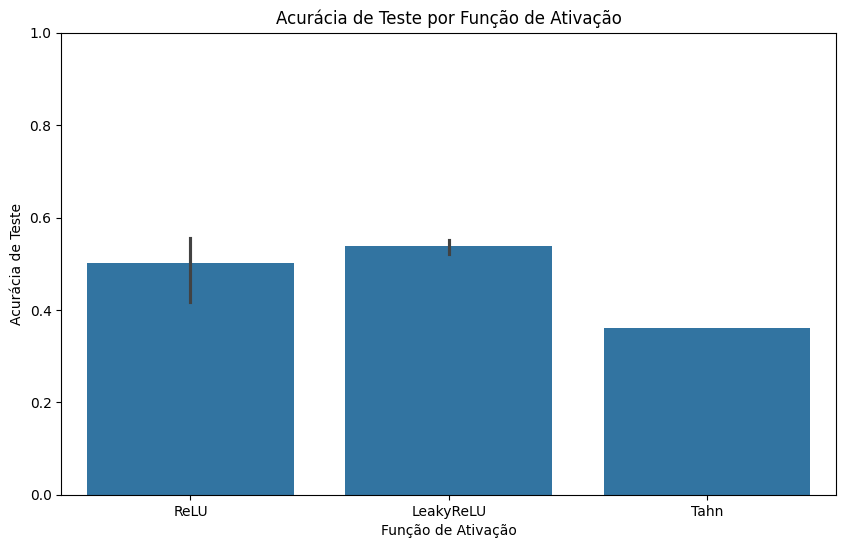

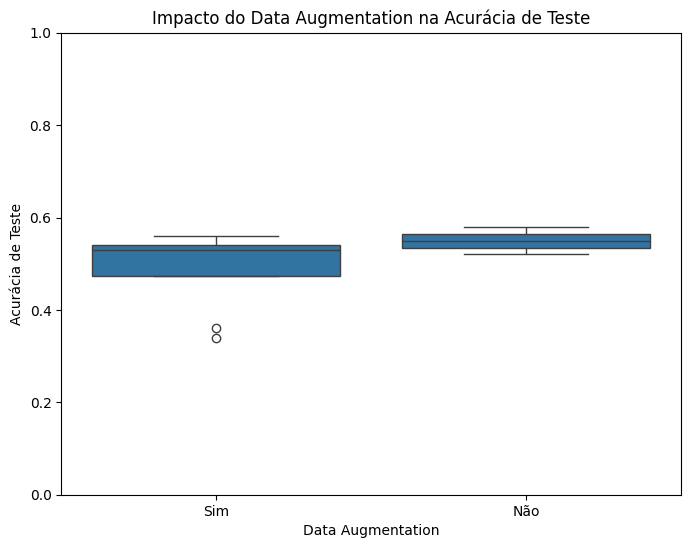

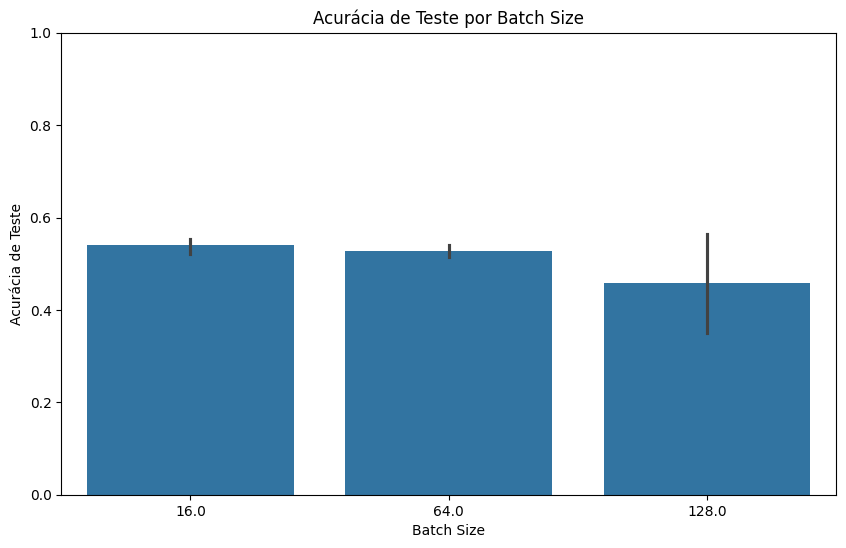

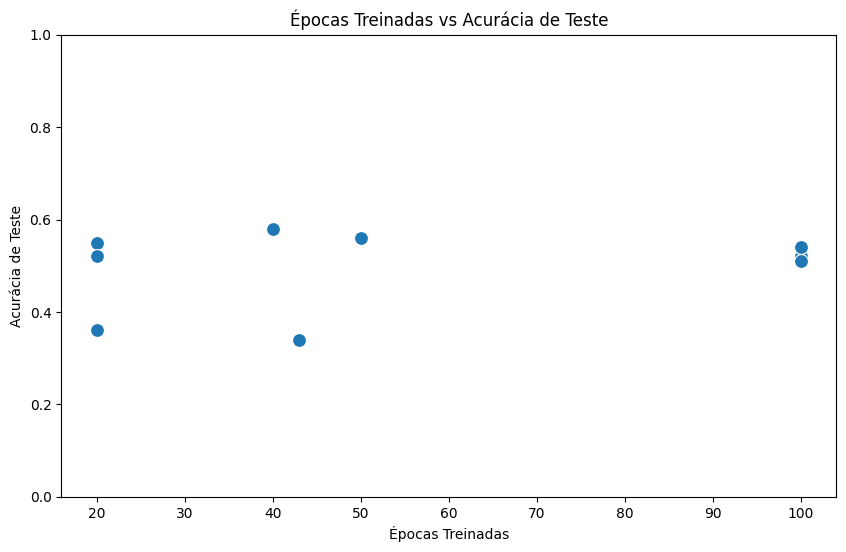


Top 5 Experimentos por Acurácia de Teste:
          Observações  Acurácia Teste  F1-Score
6   Segunda abordagem            0.58      0.58
7    Quarta abordagem            0.56      0.55
5  Primeira abordagem            0.55      0.55
3                 NaN            0.54      0.54
4    Quinta abordagem            0.54      0.54

Top 5 Experimentos por F1-Score:
          Observações  Acurácia Teste  F1-Score
6   Segunda abordagem            0.58      0.58
5  Primeira abordagem            0.55      0.55
7    Quarta abordagem            0.56      0.55
3                 NaN            0.54      0.54
4    Quinta abordagem            0.54      0.54


In [ ]:
# prompt: gere mais analise usando df que tem essas colunas Experimento	Arquitetura (Camadas/Neurônios)	Função de Ativação	Batch Size	Learning Rate	Otimizador	Dropout	Weight Decay (L2)	Data Augmentation	Épocas Treinadas	Acurácia Treino	Acurácia Teste	Precision	Recall	F1-Score	Observações	Membro

import matplotlib.pyplot as plt
# Análise da Acurácia de Teste por Função de Ativação
plt.figure(figsize=(10,6))
sns.barplot(x='Função de Ativação', y='Acurácia Teste', data=df)
plt.title('Acurácia de Teste por Função de Ativação')
plt.ylabel('Acurácia de Teste')
plt.ylim(0, 1)
plt.show()

# Análise da Acurácia de Teste pela presença/ausência de Data Augmentation
plt.figure(figsize=(8,6))
sns.boxplot(x='Data Augmentation', y='Acurácia Teste', data=df)
plt.title('Impacto do Data Augmentation na Acurácia de Teste')
plt.ylabel('Acurácia de Teste')
plt.ylim(0, 1)
plt.show()

# Análise da Acurácia de Teste pelo Batch Size
plt.figure(figsize=(10,6))
sns.barplot(x='Batch Size', y='Acurácia Teste', data=df.sort_values('Batch Size'))
plt.title('Acurácia de Teste por Batch Size')
plt.ylabel('Acurácia de Teste')
plt.ylim(0, 1)
plt.show()

# Análise da Acurácia de Teste em relação ao número de Épocas Treinadas
plt.figure(figsize=(10,6))
sns.scatterplot(x='Épocas Treinadas', y='Acurácia Teste', data=df, s=100)
plt.title('Épocas Treinadas vs Acurácia de Teste')
plt.xlabel('Épocas Treinadas')
plt.ylabel('Acurácia de Teste')
plt.ylim(0, 1)
plt.show()

# Exibindo os experimentos com as melhores acurácias
print("\nTop 5 Experimentos por Acurácia de Teste:")
print(df.sort_values(by='Acurácia Teste', ascending=False).head(5)[['Observações', 'Acurácia Teste', 'F1-Score']])

# Exibindo os experimentos com os melhores F1-Scores
print("\nTop 5 Experimentos por F1-Score:")
print(df.sort_values(by='F1-Score', ascending=False).head(5)[['Observações', 'Acurácia Teste', 'F1-Score']])
